# Experiments with news personalization simulator using Contextual Bandits


1. Experimented with reward distribution which changes once

  a. [With Learning](#scrollTo=NhL3laBM86LP&line=6&uniqifier=1)

  b. [Without Learning](#scrollTo=uCw_HSBE86LQ&line=7&uniqifier=1)

2. Experimented with multiple changes to reward distribution over time
  
  a. [With Learning](#scrollTo=8vC894ilGETD&line=7&uniqifier=1)

  b. [Without Learning](#scrollTo=YeRIBW4pGGcB&line=1&uniqifier=1)

3. Experimented with different algorithms

  a. [Different parameters of each algorithm](#scrollTo=GcSYQICtJYO4&line=1&uniqifier=1)

  b. [Comparison of best of each algorithm](#scrollTo=YApxchYQQnwZ&line=1&uniqifier=1)


4. Experimented with varying noise in reward distribution

  a. [Noise causing upto 10% change](#scrollTo=UCr3bgVNmskE&line=1&uniqifier=1)

  b. [Noise causing upto 50% change](#scrollTo=s35n5QWSoxEM&line=1&uniqifier=1)

Observations :

1. Initially, the Bagging and Softmax Explorer algorithms work well, but their performance deteriorates over time.
2. The performance of RND explorer and epsilon-greedy remains consistent over time. Overall, RND explorer seems to be the best algorithm for the task at hand.
3. Adding noise which can change reward up to 10%, doesn't affect the algorithm much. 
4. As the magnitude of noise increases, performance deteriorates, but it remains consistent over time. 
5. In each of the cases, with learning performance is significantly better than without learning


# Common

## Environment Setup

In [1]:
pip install vowpalwabbit

     |████████████████████████████████| 2.2MB 7.6MB/s 


### Import Packages

In [2]:
from vowpalwabbit import pyvw
import random
import matplotlib.pyplot as plt
import pandas as pd
import itertools


## VW format conversion

In [3]:
# This function modifies (context, action, cost, probability) to VW friendly format
def to_vw_example_format(context, actions, cb_label = None):
    if cb_label is not None:
        chosen_action, cost, prob = cb_label
    example_string = ""
    example_string += "shared |User user={} time_of_day={}\n".format(context["user"], context["time_of_day"])
    for action in actions:
        if cb_label is not None and action == chosen_action:
            example_string += "0:{}:{} ".format(cost, prob)
        example_string += "|Action article={} \n".format(action)
    #Strip the last newline
    return example_string[:-1]

## PMF to action


In [4]:
def sample_custom_pmf(pmf):
    total = sum(pmf)
    scale = 1/total
    pmf = [x * scale for x in pmf]
    draw = random.random()
    sum_prob = 0.0
    for index, prob in enumerate(pmf):
        sum_prob += prob
        if(sum_prob > draw):
            return index, prob

## Get Action

In [5]:
def get_action(vw, context, actions):
    vw_text_example = to_vw_example_format(context,actions)
    pmf = vw.predict(vw_text_example)
    chosen_action_index, prob = sample_custom_pmf(pmf)
    return actions[chosen_action_index], prob

## Plots

In [6]:
def plot_ctr(num_iterations, ctr, title='Performance vs Iterations', size=(10,7)):
    plt.rcParams["figure.figsize"] = size
    plt.plot(range(1,num_iterations+1), ctr)
    plt.xlabel('num_iterations', fontsize=14)
    plt.ylabel('ctr', fontsize=14)
    plt.title(title)
    plt.ylim([0,1])

In [7]:
def plot_ctr_multiple(num_iterations, ctrs, labels=[], title='Different Algorithms Performance', size=(20,10)):
    plt.rcParams["figure.figsize"] = size
    for ctr in ctrs:
      plt.plot(range(1,num_iterations+1), ctr)
    plt.xlabel('num_iterations', fontsize=14)
    plt.legend(labels)
    plt.ylabel('ctr', fontsize=14)
    plt.ylim([0,1])
    plt.title(title)



## Simulation set up



In [8]:
users = ['Tom', 'Anna']
times_of_day = ['morning', 'afternoon']
actions = ["politics", "sports", "music", "food", "finance", "health", "camping"]

# display preference matrix
def get_preference_matrix(cost_fun):
    def expand_grid(data_dict):
        rows = itertools.product(*data_dict.values())
        return pd.DataFrame.from_records(rows, columns=data_dict.keys())

    df = expand_grid({'users':users, 'times_of_day': times_of_day, 'actions': actions})
    df['cost'] = df.apply(lambda r: cost_fun({'user': r[0], 'time_of_day': r[1]}, r[2]), axis=1)

    return df.pivot_table(index=['users', 'times_of_day'], 
            columns='actions', 
            values='cost')

In [9]:
def choose_user(users):
    return random.choice(users)

def choose_time_of_day(times_of_day):
    return random.choice(times_of_day)

In [10]:
def run_simulation_multiple_cost_functions(vw, num_iterations, users, times_of_day, actions, cost_functions, do_learn = True):
    cost_sum = 0.
    ctr = []

    start_counter = 1
    end_counter = start_counter + num_iterations
    for cost_function in cost_functions:
        for i in range(start_counter, end_counter):
            # 1. in each simulation choose a user
            user = choose_user(users)
            # 2. choose time of day for a given user
            time_of_day = choose_time_of_day(times_of_day)

            # Construct context based on chosen user and time of day
            context = {'user': user, 'time_of_day': time_of_day}

            # 3. Use the get_action function we defined earlier
            action, prob = get_action(vw, context, actions)

            # 4. Get cost of the action we chose
            cost = cost_function(context, action)
            cost_sum += cost

            if do_learn:
                # 5. Inform VW of what happened so we can learn from it
                vw_format = vw.parse(to_vw_example_format(context, actions, (action, cost, prob)),pyvw.vw.lContextualBandit)
                # 6. Learn
                vw.learn(vw_format)

            # We negate this so that on the plot instead of minimizing cost, we are maximizing reward
            ctr.append(-1*cost_sum/i)
        start_counter = end_counter
        end_counter = start_counter + num_iterations

    return ctr

## Reward Functions

In [11]:
# VW tries to minimize loss/cost, therefore we will pass cost as -reward
USER_LIKED_ARTICLE = -1.0
USER_DISLIKED_ARTICLE = 0.0

In [12]:
def get_cost(context,action):
    if context['user'] == "Tom":
        if context['time_of_day'] == "morning" and action == 'politics':
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == 'music':
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE
    elif context['user'] == "Anna":
        if context['time_of_day'] == "morning" and action == 'sports':
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == 'politics':
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE

get_preference_matrix(get_cost)

actions             camping  finance  food  health  music  politics  sports
users times_of_day                                                         
Anna  afternoon         0.0      0.0   0.0     0.0    0.0      -1.0     0.0
      morning           0.0      0.0   0.0     0.0    0.0       0.0    -1.0
Tom   afternoon         0.0      0.0   0.0     0.0   -1.0       0.0     0.0
      morning           0.0      0.0   0.0     0.0    0.0      -1.0     0.0

In [13]:
def get_cost_new1(context,action):
    if context['user'] == "Tom":
        if context['time_of_day'] == "morning" and action == 'politics':
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == 'sports':
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE
    elif context['user'] == "Anna":
        if context['time_of_day'] == "morning" and action == 'sports':
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == 'sports':
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE
        
get_preference_matrix(get_cost_new1)

actions             camping  finance  food  health  music  politics  sports
users times_of_day                                                         
Anna  afternoon         0.0      0.0   0.0     0.0    0.0       0.0    -1.0
      morning           0.0      0.0   0.0     0.0    0.0       0.0    -1.0
Tom   afternoon         0.0      0.0   0.0     0.0    0.0       0.0    -1.0
      morning           0.0      0.0   0.0     0.0    0.0      -1.0     0.0

In [14]:
def get_cost_new2(context,action):
    if context['user'] == "Tom":
        if context['time_of_day'] == "morning" and action == 'health':
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == 'sports':
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE
    elif context['user'] == "Anna":
        if context['time_of_day'] == "morning" and action == 'sports':
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == 'finance':
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE
        
get_preference_matrix(get_cost_new2)

actions             camping  finance  food  health  music  politics  sports
users times_of_day                                                         
Anna  afternoon         0.0     -1.0   0.0     0.0    0.0       0.0     0.0
      morning           0.0      0.0   0.0     0.0    0.0       0.0    -1.0
Tom   afternoon         0.0      0.0   0.0     0.0    0.0       0.0    -1.0
      morning           0.0      0.0   0.0    -1.0    0.0       0.0     0.0

In [15]:
def get_cost_new3(context,action):
    if context['user'] == "Tom":
        if context['time_of_day'] == "morning" and action == 'health':
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == 'health':
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE
    elif context['user'] == "Anna":
        if context['time_of_day'] == "morning" and action == 'food':
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == 'finance':
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE
        
get_preference_matrix(get_cost_new3)

actions             camping  finance  food  health  music  politics  sports
users times_of_day                                                         
Anna  afternoon         0.0     -1.0   0.0     0.0    0.0       0.0     0.0
      morning           0.0      0.0  -1.0     0.0    0.0       0.0     0.0
Tom   afternoon         0.0      0.0   0.0    -1.0    0.0       0.0     0.0
      morning           0.0      0.0   0.0    -1.0    0.0       0.0     0.0

# Reward distribution changing once




### Tom

| | `get_cost` | `get_cost_new1` |
|:---|:---:|:---:|
| **Morning** | Politics | Politics |
| **Afternoon** | Music | Sports |

### Anna

| | `get_cost` | `get_cost_new1`  |
|:---|:---:|:---:|
| **Morning** | Sports | Sports |
| **Afternoon** | Politics | Sports |

### With learning


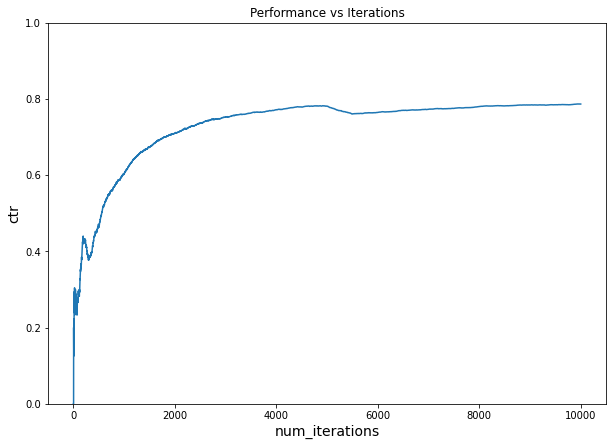

In [16]:
# use first reward function initially and then switch to second reward function

# Instantiate learner in VW
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --epsilon 0.2")

num_iterations_per_cost_func = 5000
cost_functions = [get_cost, get_cost_new1]
total_iterations = num_iterations_per_cost_func * len(cost_functions)

ctr = run_simulation_multiple_cost_functions(vw, num_iterations_per_cost_func, users, times_of_day, actions, cost_functions)

plot_ctr(total_iterations, ctr)


### Without learning

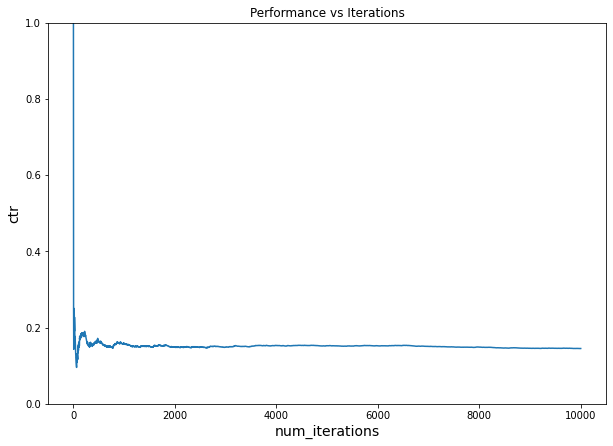

In [17]:
# Do not learn
# use first reward function initially and then switch to second reward function

# Instantiate learner in VW
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --epsilon 0.2")

num_iterations_per_cost_func = 5000
cost_functions = [get_cost, get_cost_new1]
total_iterations = num_iterations_per_cost_func * len(cost_functions)

ctr = run_simulation_multiple_cost_functions(vw, num_iterations_per_cost_func, users, times_of_day, actions, cost_functions, do_learn=False)
plot_ctr(total_iterations, ctr)

# Multiple Changes in reward distribution





### Tom

| | `get_cost` | `get_cost_new1` | `get_cost_new2` | `get_cost_new3` |
|:---|:---:|:---:| :---:|:---:|
| **Morning** | Politics | Politics | Health | Health |
| **Afternoon** | Music | Sports | Sports | Health |

### Anna

| | `get_cost` | `get_cost_new1`  | `get_cost_new2` | `get_cost_new3` |
|:---|:---:|:---:| :---:|:---:|
| **Morning** | Sports | Sports | Sports | Food |
| **Afternoon** | Politics | Sports | Finance | Finance |

### With Learning

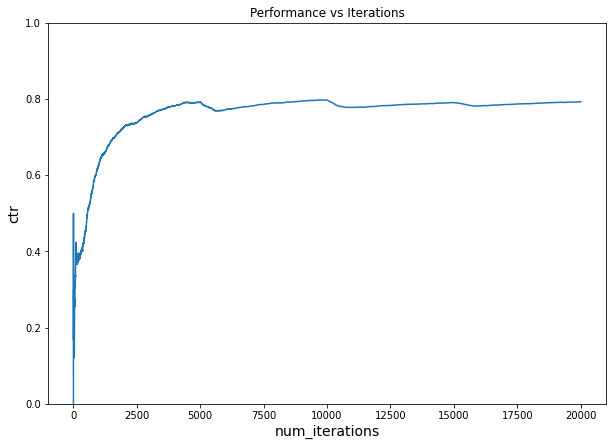

In [18]:
# use first reward function initially and then switch to second reward function

# Instantiate learner in VW
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --epsilon 0.2")

num_iterations_per_cost_func = 5000
cost_functions = [get_cost, get_cost_new1, get_cost_new2, get_cost_new3]
total_iterations = num_iterations_per_cost_func * len(cost_functions)

ctr = run_simulation_multiple_cost_functions(vw, num_iterations_per_cost_func, users, times_of_day, actions, cost_functions)

plot_ctr(total_iterations, ctr)

### Without Learning

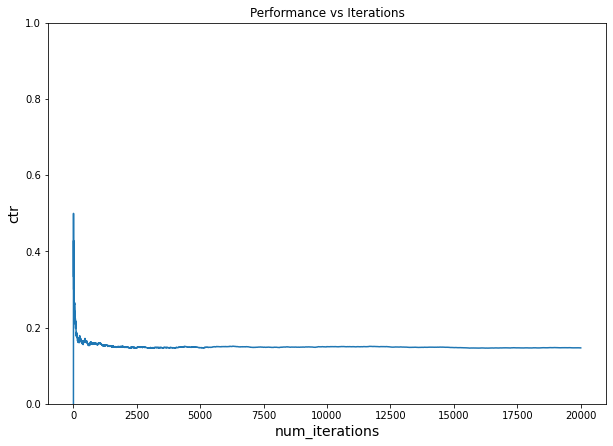

In [19]:
# Do not learn
# use first reward function initially and then switch to second reward function

# Instantiate learner in VW
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --epsilon 0.2")

num_iterations_per_cost_func = 5000
cost_functions = [get_cost, get_cost_new1, get_cost_new2, get_cost_new3]
total_iterations = num_iterations_per_cost_func * len(cost_functions)

ctr = run_simulation_multiple_cost_functions(vw, num_iterations_per_cost_func, users, times_of_day, actions, cost_functions, do_learn=False)
plot_ctr(total_iterations, ctr)

#Different Algorithms

### Epsilon-greedy

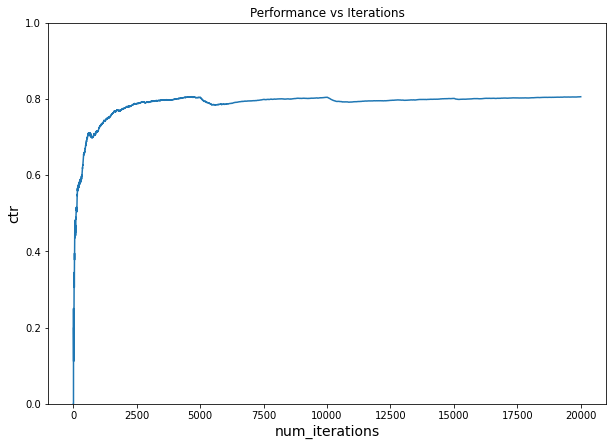

In [34]:
# use first reward function initially and then switch to second reward function

# Instantiate learner in VW
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --epsilon 0.2")

num_iterations_per_cost_func = 5000
cost_functions = [get_cost, get_cost_new1, get_cost_new2, get_cost_new3]
total_iterations = num_iterations_per_cost_func * len(cost_functions)

ctr = run_simulation_multiple_cost_functions(vw, num_iterations_per_cost_func, users, times_of_day, actions, cost_functions)

plot_ctr(total_iterations, ctr)

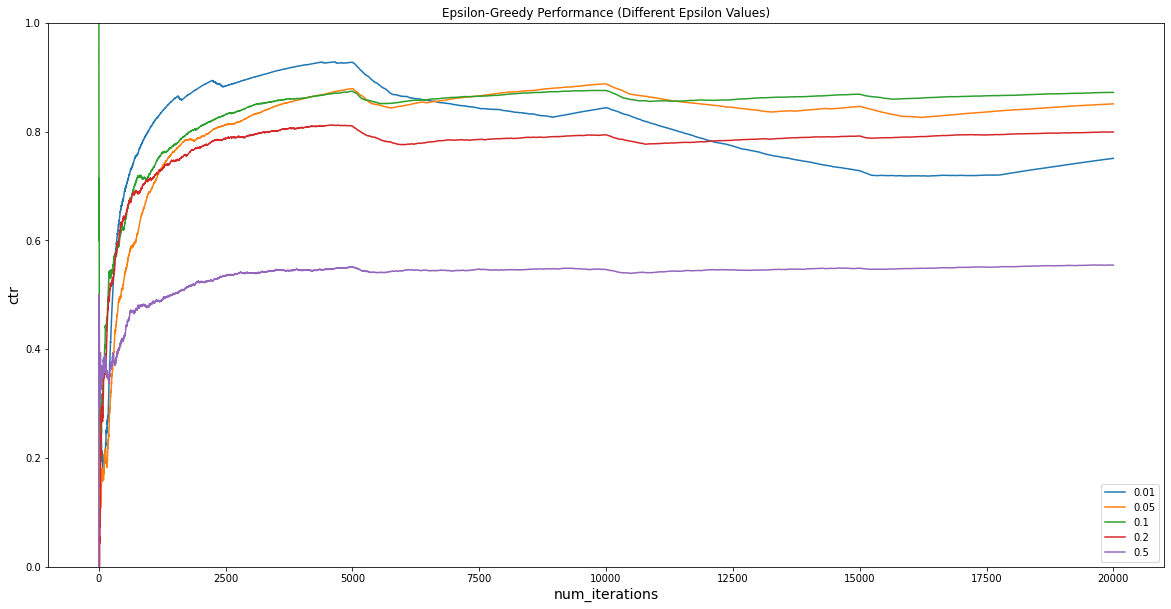

In [35]:
num_iterations_per_cost_func = 5000
cost_functions = [get_cost, get_cost_new1, get_cost_new2, get_cost_new3]
total_iterations = num_iterations_per_cost_func * len(cost_functions)

ctrs = []
epsilons = [0.01,0.05,0.1,0.2,0.5]
for eps in epsilons:
  ctr = run_simulation_multiple_cost_functions(pyvw.vw("--cb_explore_adf -q UA --quiet --epsilon {}".format(eps)), num_iterations_per_cost_func, users, times_of_day, actions, cost_functions)
  ctrs.append(ctr)

plot_ctr_multiple(total_iterations, ctrs, epsilons, title='Epsilon-Greedy Performance (Different Epsilon Values)')

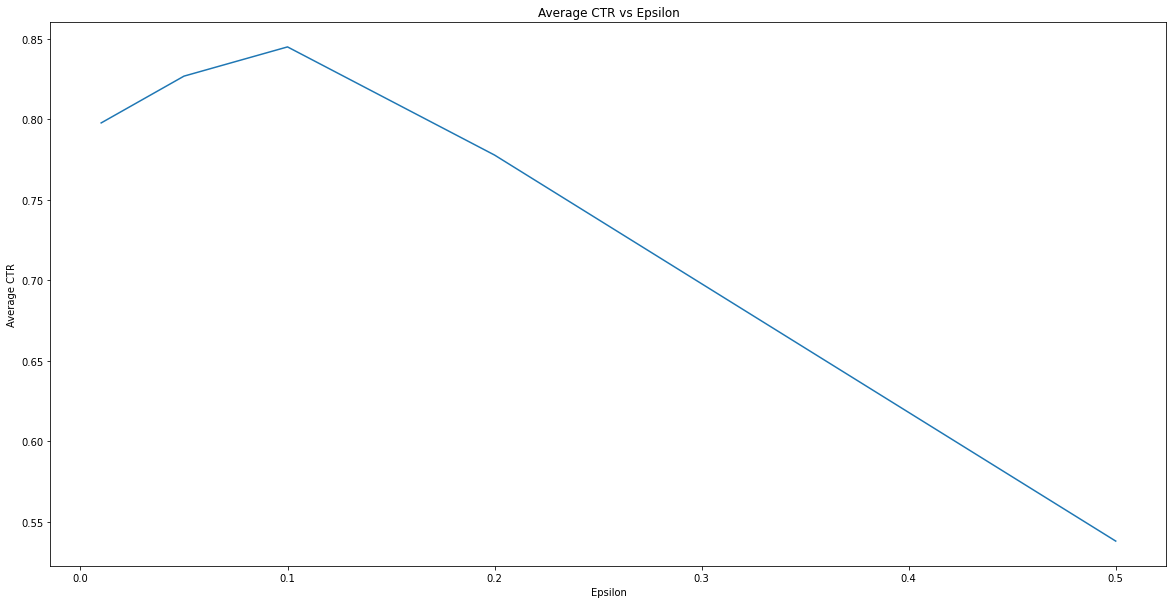

In [36]:
ctrs_avg = [sum(ctr)/total_iterations for ctr in ctrs]
ctr_eps = max(ctrs, key=lambda lst:sum(lst)/total_iterations)
plt.plot(epsilons, ctrs_avg)
plt.xlabel('Epsilon')
plt.ylabel('Average CTR')
plt.title('Average CTR vs Epsilon')
plt.show()

### Explore-first

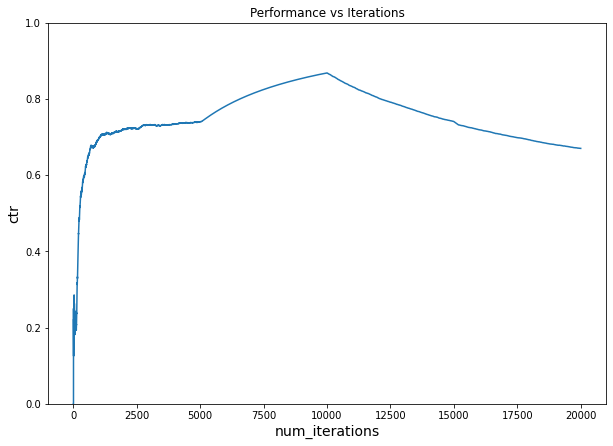

In [37]:
# use first reward function initially and then switch to second reward function

# Instantiate learner in VW
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --first 2")

num_iterations_per_cost_func = 5000
cost_functions = [get_cost, get_cost_new1, get_cost_new2, get_cost_new3]
total_iterations = num_iterations_per_cost_func * len(cost_functions)

ctr_first = run_simulation_multiple_cost_functions(vw, num_iterations_per_cost_func, users, times_of_day, actions, cost_functions)

plot_ctr(total_iterations, ctr_first)

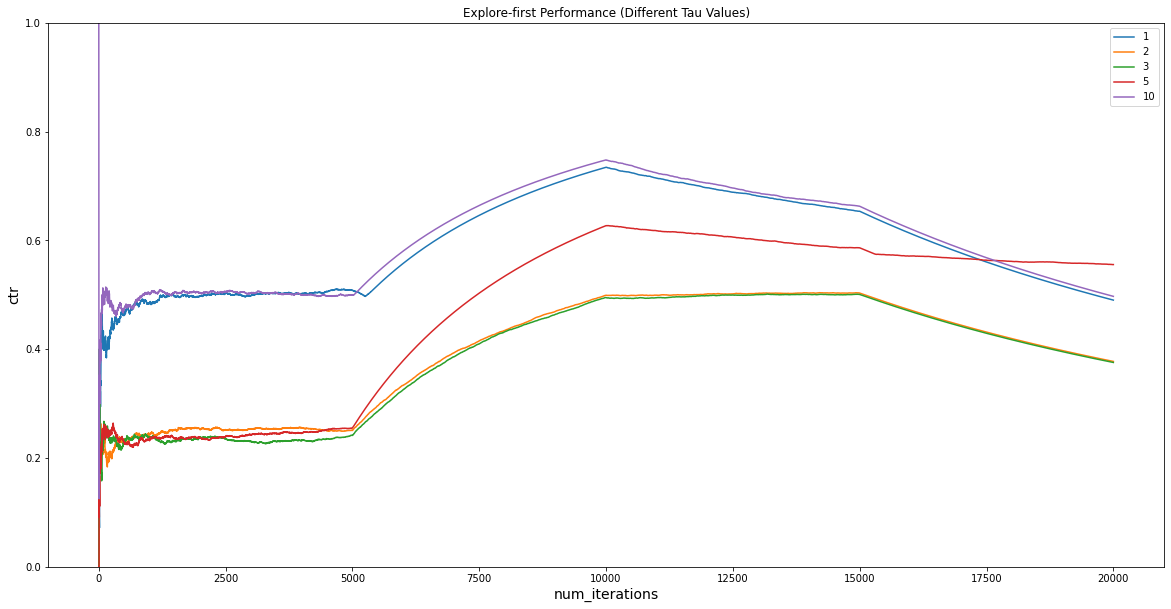

In [38]:
num_iterations_per_cost_func = 5000
cost_functions = [get_cost, get_cost_new1, get_cost_new2, get_cost_new3]
total_iterations = num_iterations_per_cost_func * len(cost_functions)

ctrs = []
taus = [1,2,3,5,10]
for tau in taus:
  ctr = run_simulation_multiple_cost_functions(pyvw.vw("--cb_explore_adf -q UA --quiet --first {}".format(tau)), num_iterations_per_cost_func, users, times_of_day, actions, cost_functions)
  ctrs.append(ctr)

plot_ctr_multiple(total_iterations, ctrs, taus, title='Explore-first Performance (Different Tau Values)')

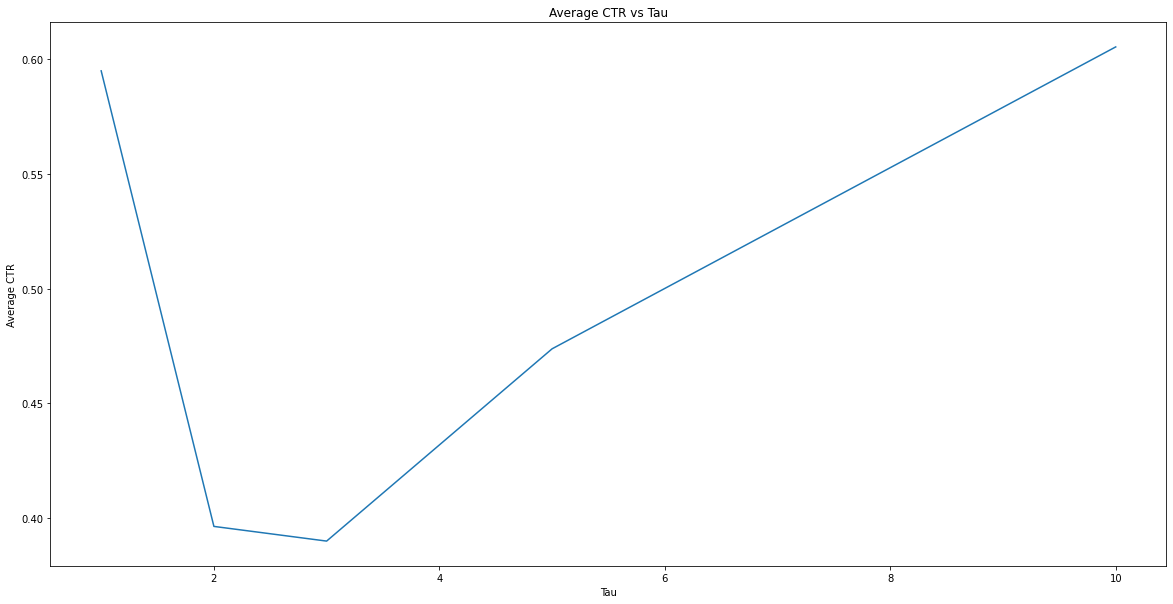

In [39]:
ctrs_avg = [sum(ctr)/total_iterations for ctr in ctrs]
ctr_first = max(ctrs, key=lambda lst:sum(lst)/total_iterations)
plt.plot(taus, ctrs_avg)
plt.xlabel('Tau')
plt.ylabel('Average CTR')
plt.title('Average CTR vs Tau')
plt.show()

### Bagging Explorer

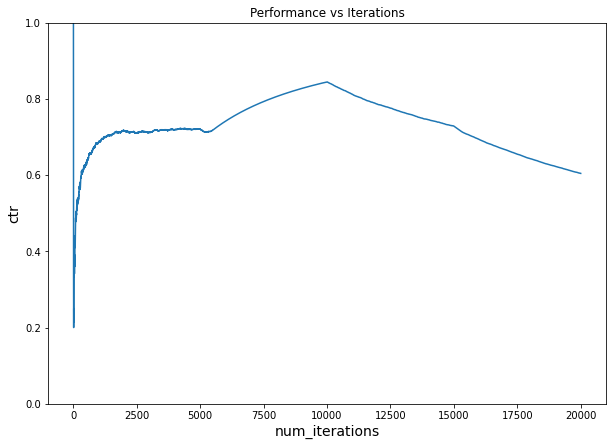

In [40]:
# use first reward function initially and then switch to second reward function

# Instantiate learner in VW
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --bag 5")

num_iterations_per_cost_func = 5000
cost_functions = [get_cost, get_cost_new1, get_cost_new2, get_cost_new3]
total_iterations = num_iterations_per_cost_func * len(cost_functions)

ctr_bag = run_simulation_multiple_cost_functions(vw, num_iterations_per_cost_func, users, times_of_day, actions, cost_functions)

plot_ctr(total_iterations, ctr_bag)

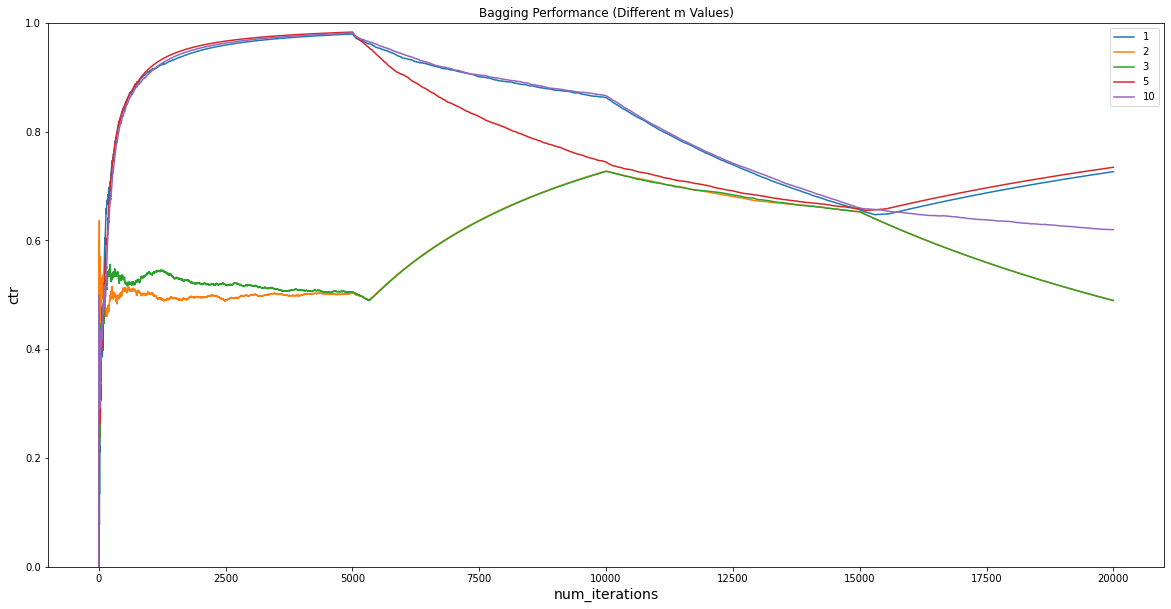

In [41]:
num_iterations_per_cost_func = 5000
cost_functions = [get_cost, get_cost_new1, get_cost_new2, get_cost_new3]
total_iterations = num_iterations_per_cost_func * len(cost_functions)

ctrs = []
bags = [1,2,3,5,10]
for bag in bags:
  ctr = run_simulation_multiple_cost_functions(pyvw.vw("--cb_explore_adf -q UA --quiet --bag {}".format(tau)), num_iterations_per_cost_func, users, times_of_day, actions, cost_functions)
  ctrs.append(ctr)

plot_ctr_multiple(total_iterations, ctrs, bags, title='Bagging Performance (Different m Values)')

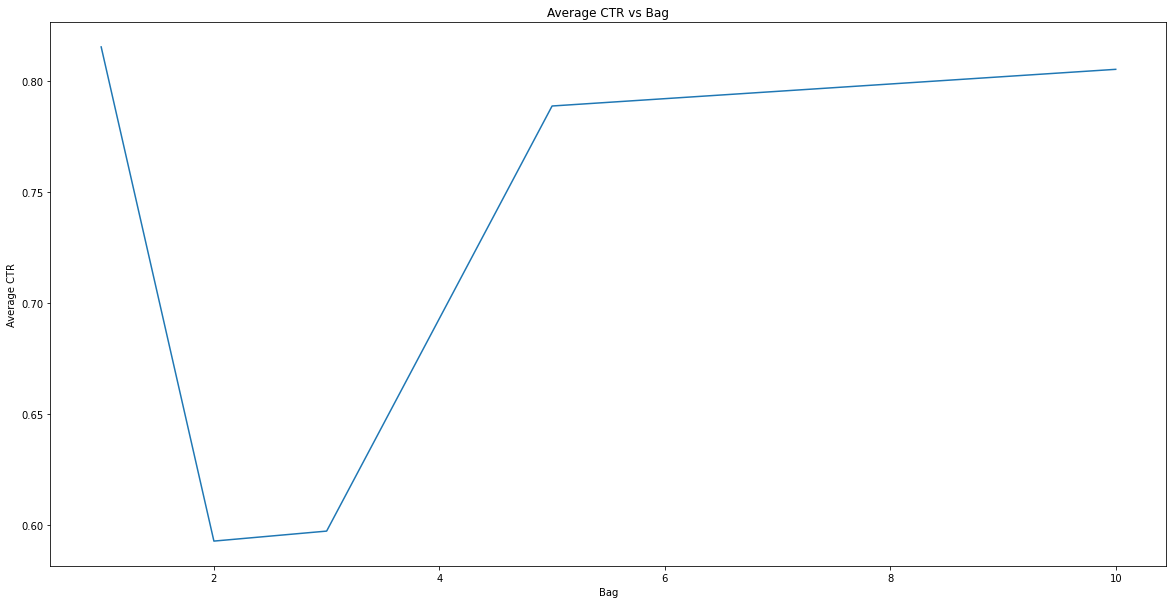

In [42]:
ctrs_avg = [sum(ctr)/total_iterations for ctr in ctrs]
ctr_bag = max(ctrs, key=lambda lst:sum(lst)/total_iterations)
plt.plot(bags, ctrs_avg)
plt.xlabel('Bag')
plt.ylabel('Average CTR')
plt.title('Average CTR vs Bag')
plt.show()

### Softmax Explorer

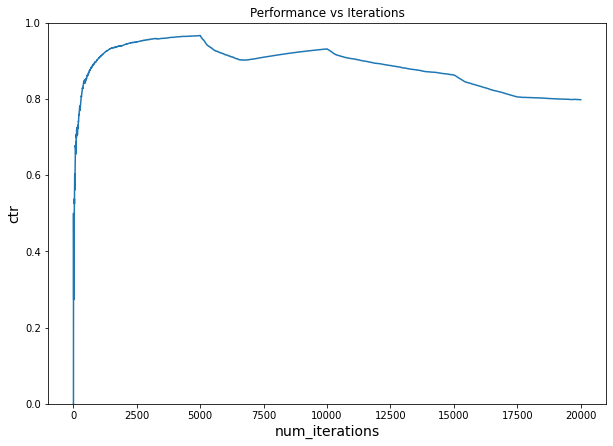

In [43]:
# use first reward function initially and then switch to second reward function

# Instantiate learner in VW
vw = pyvw.vw("--cb_explore_adf -q UA --softmax --lambda 10")

num_iterations_per_cost_func = 5000
cost_functions = [get_cost, get_cost_new1, get_cost_new2, get_cost_new3]
total_iterations = num_iterations_per_cost_func * len(cost_functions)

ctr_softmax = run_simulation_multiple_cost_functions(vw, num_iterations_per_cost_func, users, times_of_day, actions, cost_functions)

plot_ctr(total_iterations, ctr_softmax)

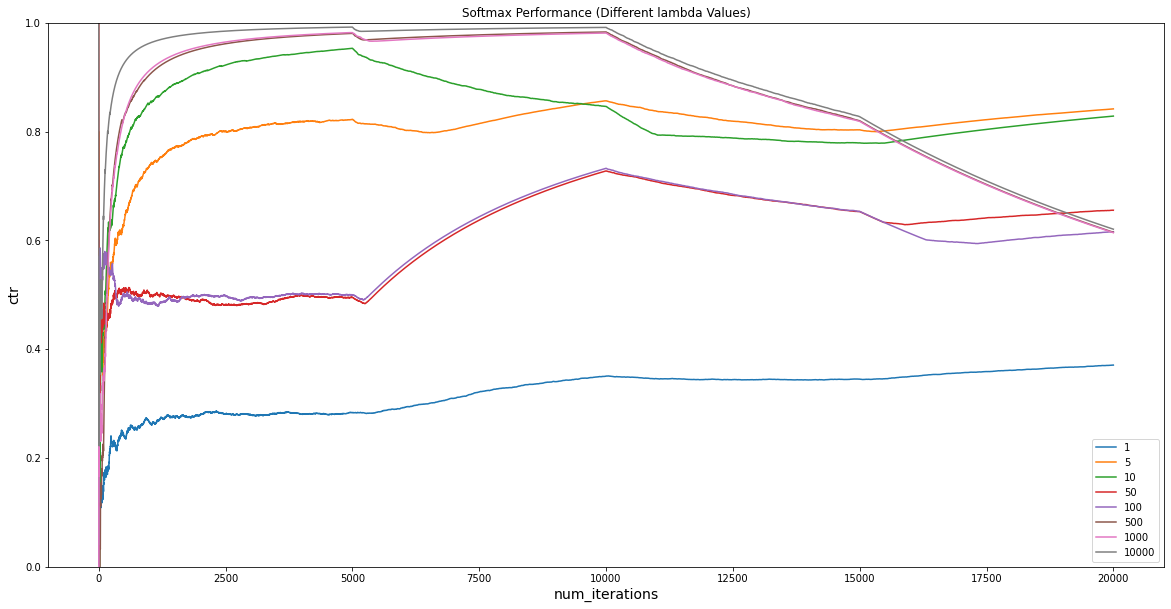

In [44]:
num_iterations_per_cost_func = 5000
cost_functions = [get_cost, get_cost_new1, get_cost_new2, get_cost_new3]
total_iterations = num_iterations_per_cost_func * len(cost_functions)

ctrs = []
lambdas = [1,5,10,50,100,500,1000,10000]
for lmbda in lambdas:
  ctr = run_simulation_multiple_cost_functions(pyvw.vw("--cb_explore_adf -q UA --quiet --softmax --lambda {}".format(lmbda)), num_iterations_per_cost_func, users, times_of_day, actions, cost_functions)
  ctrs.append(ctr)

plot_ctr_multiple(total_iterations, ctrs, lambdas, title='Softmax Performance (Different lambda Values)')

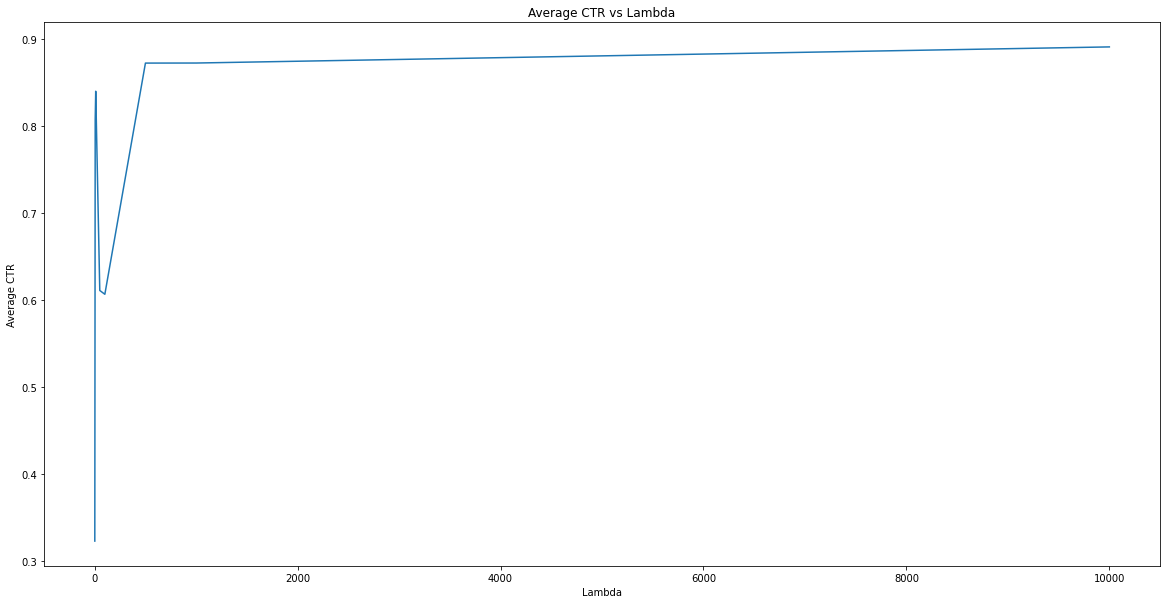

In [45]:
ctrs_avg = [sum(ctr)/total_iterations for ctr in ctrs]
ctr_softmax = max(ctrs, key=lambda lst:sum(lst)/total_iterations)
plt.plot(lambdas, ctrs_avg)
plt.xlabel('Lambda')
plt.ylabel('Average CTR')
plt.title('Average CTR vs Lambda')
plt.show()

### RND Explorer

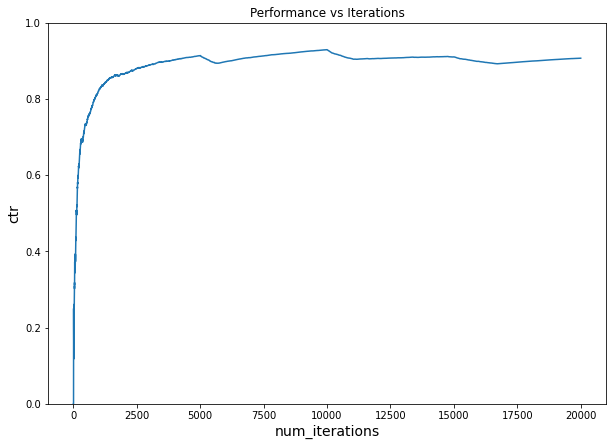

In [46]:
# use first reward function initially and then switch to second reward function

# Instantiate learner in VW
vw = pyvw.vw("--cb_explore_adf -q UA --rnd 3 --epsilon 0.025 ")

num_iterations_per_cost_func = 5000
cost_functions = [get_cost, get_cost_new1, get_cost_new2, get_cost_new3]
total_iterations = num_iterations_per_cost_func * len(cost_functions)

ctr_rnd = run_simulation_multiple_cost_functions(vw, num_iterations_per_cost_func, users, times_of_day, actions, cost_functions)

plot_ctr(total_iterations, ctr_rnd)

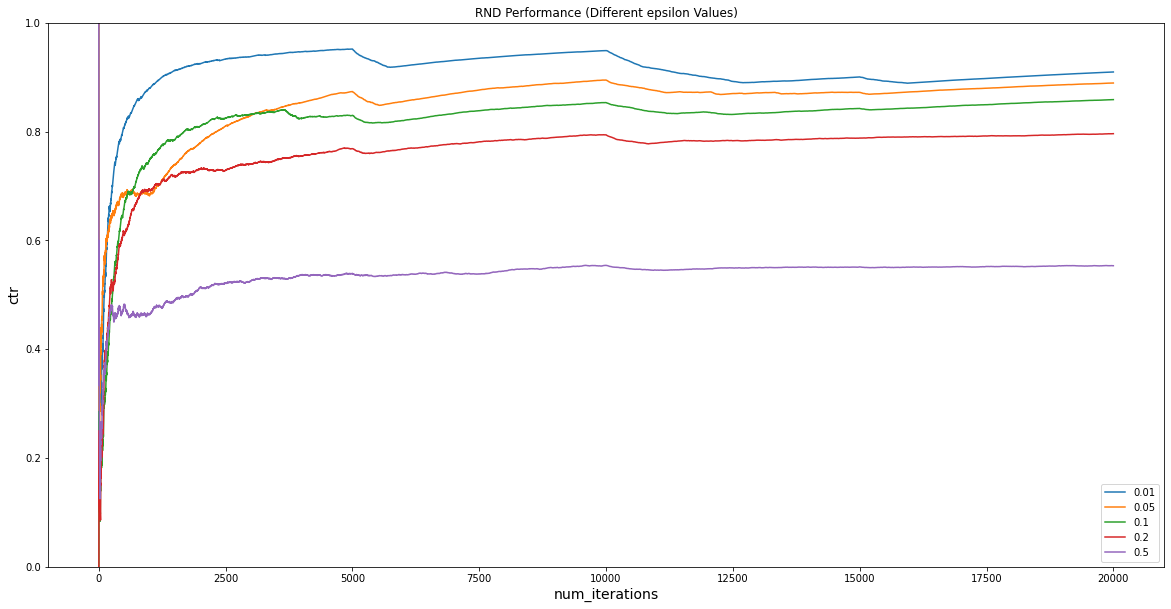

In [47]:
num_iterations_per_cost_func = 5000
cost_functions = [get_cost, get_cost_new1, get_cost_new2, get_cost_new3]
total_iterations = num_iterations_per_cost_func * len(cost_functions)

ctrs = []
epsilons = [0.01,0.05,0.1,0.2,0.5]
for eps in epsilons:
  ctr = run_simulation_multiple_cost_functions(pyvw.vw("--cb_explore_adf -q UA --quiet --rnd 3 --epsilon {}".format(eps)), num_iterations_per_cost_func, users, times_of_day, actions, cost_functions)
  ctrs.append(ctr)

plot_ctr_multiple(total_iterations, ctrs, epsilons, title='RND Performance (Different epsilon Values)')

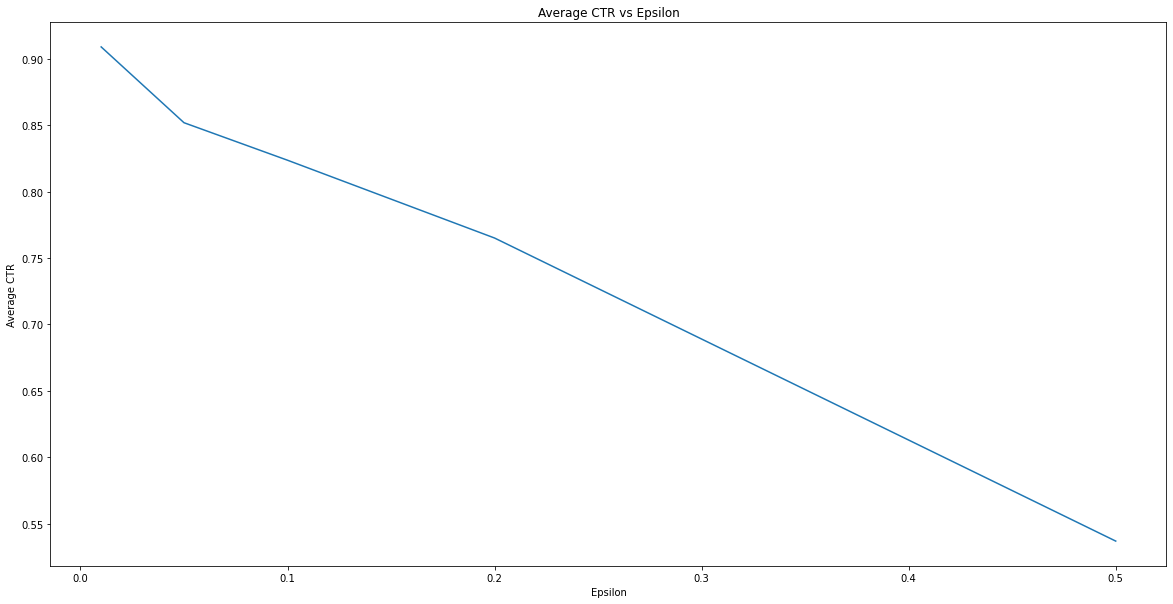

In [49]:
ctrs_avg = [sum(ctr)/total_iterations for ctr in ctrs]
ctr_rnd = max(ctrs, key=lambda lst:sum(lst)/total_iterations)
plt.plot(epsilons, ctrs_avg)
plt.xlabel('Epsilon')
plt.ylabel('Average CTR')
plt.title('Average CTR vs Epsilon')
plt.show()

## Comparison of best of different algorithms




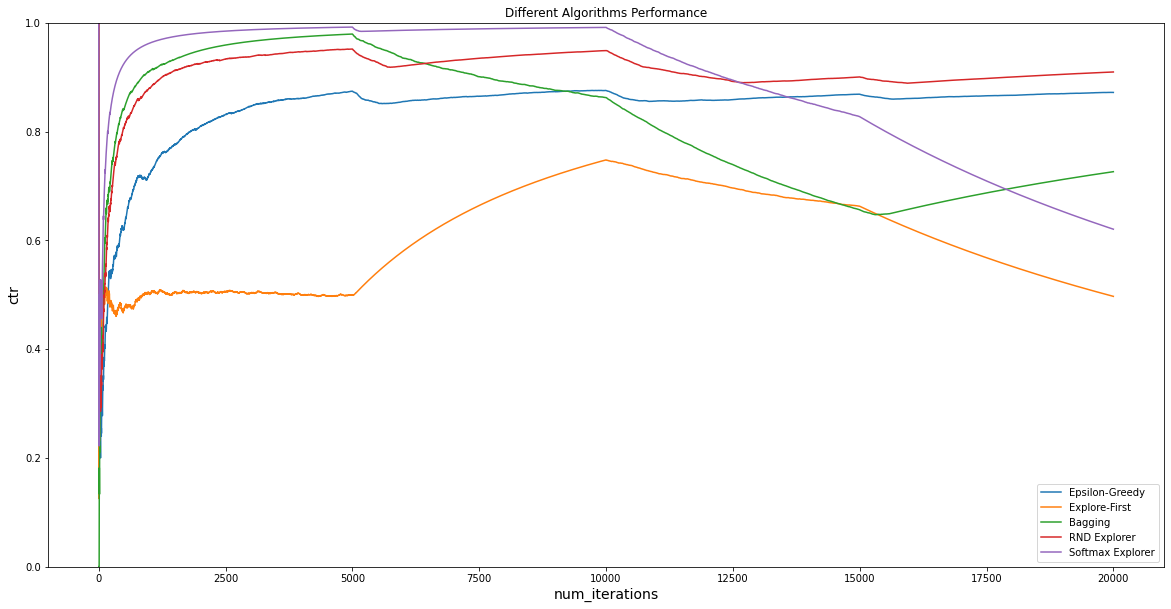

In [50]:
plot_ctr_multiple(total_iterations, [ctr_eps,ctr_first,ctr_bag,ctr_rnd,ctr_softmax], ['Epsilon-Greedy','Explore-First','Bagging','RND Explorer','Softmax Explorer'])

# Noise in reward distribution

## Reward distribution with varying noise ( Upto 10% noise )

In [53]:
import random
def get_cost_random(context,action):
    return get_cost_new1(context, action)+random.random()*0.1
    
        
get_preference_matrix(get_cost_random)

actions              camping   finance      food  ...     music  politics    sports
users times_of_day                                ...                              
Anna  afternoon     0.001649  0.073853  0.024715  ...  0.093080  0.068126 -0.904033
      morning       0.061206  0.069165  0.021592  ...  0.040433  0.067790 -0.930888
Tom   afternoon     0.021669  0.020711  0.052665  ...  0.021949  0.085526 -0.976042
      morning       0.092502  0.016837  0.018995  ...  0.067220 -0.914863  0.052126

[4 rows x 7 columns]

### With learning

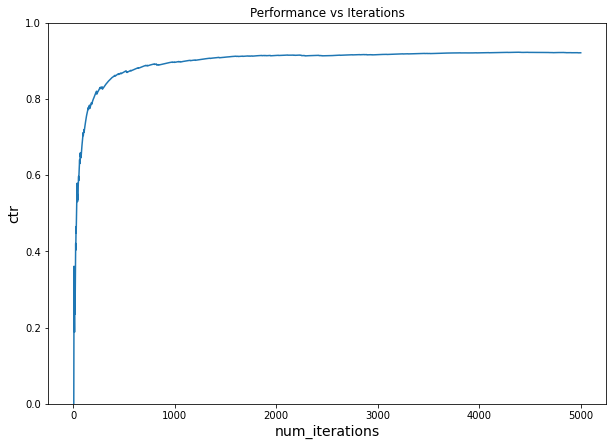

In [54]:
# use first reward function initially and then switch to second reward function

# Instantiate learner in VW
vw = pyvw.vw("--cb_explore_adf -q UA --rnd 3 --epsilon 0.025 ")

num_iterations_per_cost_func = 5000
cost_functions = [get_cost_random]
total_iterations = num_iterations_per_cost_func * len(cost_functions)

ctr_rnd = run_simulation_multiple_cost_functions(vw, num_iterations_per_cost_func, users, times_of_day, actions, cost_functions)

plot_ctr(total_iterations, ctr_rnd)

### Without Learning

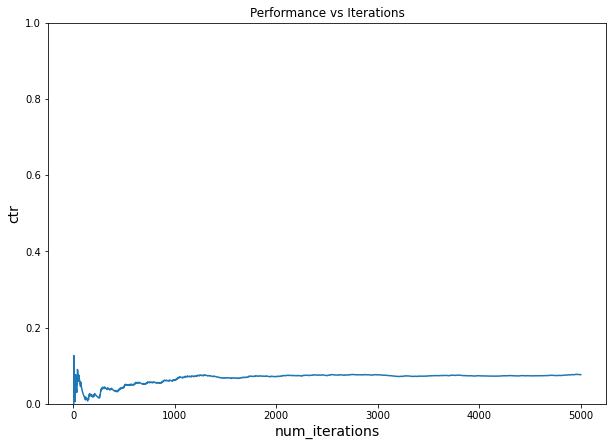

In [57]:
# use first reward function initially and then switch to second reward function

# Instantiate learner in VW
vw = pyvw.vw("--cb_explore_adf -q UA --rnd 3 --epsilon 0.025 ")

num_iterations_per_cost_func = 5000
cost_functions = [get_cost_random]
total_iterations = num_iterations_per_cost_func * len(cost_functions)

ctr_rnd = run_simulation_multiple_cost_functions(vw, num_iterations_per_cost_func, users, times_of_day, actions, cost_functions, do_learn=False)

plot_ctr(total_iterations, ctr_rnd)

## Reward distribution with varying noise ( Upto 50% noise )

In [59]:
import random
def get_cost_random_half(context,action):
    return get_cost_new1(context, action)+random.random()*0.5
    
        
get_preference_matrix(get_cost_random_half)

actions              camping   finance      food  ...     music  politics    sports
users times_of_day                                ...                              
Anna  afternoon     0.484054  0.342426  0.125114  ...  0.336737  0.275862 -0.902117
      morning       0.124884  0.425993  0.441952  ...  0.104168  0.272403 -0.938284
Tom   afternoon     0.169627  0.442944  0.245942  ...  0.374475  0.212426 -0.948863
      morning       0.244698  0.133567  0.189144  ...  0.420252 -0.618014  0.492841

[4 rows x 7 columns]

### With Learning

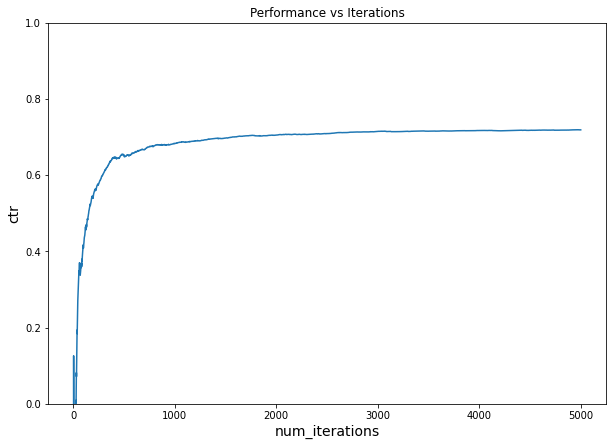

In [60]:
# use first reward function initially and then switch to second reward function

# Instantiate learner in VW
vw = pyvw.vw("--cb_explore_adf -q UA --rnd 3 --epsilon 0.025 ")

num_iterations_per_cost_func = 5000
cost_functions = [get_cost_random_half]
total_iterations = num_iterations_per_cost_func * len(cost_functions)

ctr_rnd = run_simulation_multiple_cost_functions(vw, num_iterations_per_cost_func, users, times_of_day, actions, cost_functions)

plot_ctr(total_iterations, ctr_rnd)

### Without learning

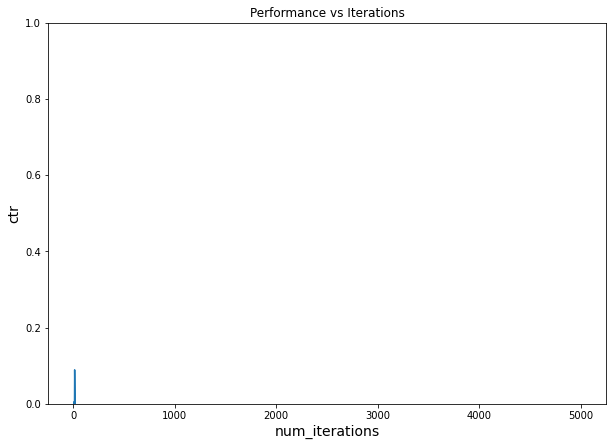

In [61]:
# use first reward function initially and then switch to second reward function

# Instantiate learner in VW
vw = pyvw.vw("--cb_explore_adf -q UA --rnd 3 --epsilon 0.025 ")

num_iterations_per_cost_func = 5000
cost_functions = [get_cost_random_half]
total_iterations = num_iterations_per_cost_func * len(cost_functions)

ctr_rnd = run_simulation_multiple_cost_functions(vw, num_iterations_per_cost_func, users, times_of_day, actions, cost_functions, do_learn=False)

plot_ctr(total_iterations, ctr_rnd)